In [34]:
%matplotlib inline
import matplotlib.pyplot as plt


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Data Preprocessing

In [1]:
from google.colab import drive
drive.mount('/content/drive')   # address of files is /content/drive/MyDrive/vr_dataset

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/vr_dataset/split1.csv') # replace this with your split1.csv files address to run

In [ ]:
df.head()

,image_id,height,width,path
0,61zYW6KGsIL,1500,1500,00/00000529.jpg
1,61zhDjspH5L,1001,1001,00/00003a93.jpg
2,61hQ0G8v1PL,1001,1001,00/000088e1.jpg
3,B1PzPj1a2zS,2560,2560,00/0000b301.jpg
4,716FUz7mdWL,1908,1908,00/0000b9b8.jpg


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109012 entries, 0 to 109011
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   image_id  109012 non-null  object
 1   height    109012 non-null  int64 
 2   width     109012 non-null  int64 
 3   path      109012 non-null  object
dtypes: int64(2), object(2)
memory usage: 3.3+ MB


In [ ]:
# Check the total count of missing values
missing_values_count = df.isnull().sum().sum()

print(f"Total missing values in the dataset: {missing_values_count}")

Total missing values in the dataset: 0


In [ ]:
df.columns

Index(['image_id', 'height', 'width', 'path'], dtype='object')

# Generating the VQA using gemini

In [ ]:
# Run this once in your environment to install packages:
# !pip install google-generativeai pandas tqdm pillow

import os
import json
import sqlite3

import google.generativeai as genai
import pandas as pd
from PIL import Image
from tqdm import tqdm


In [ ]:
'''  Run this code to generate vqa
# Configure API (Replace with your API Key)
genai.configure(api_key="")  # PASTE YOUR API KEY HERE
'''


In [ ]:
'''
No need to run this code as we already have generated the vqa
# Initialize multimodal vision model
model = genai.GenerativeModel("gemini-1.5-flash")

# Define number of images to process
num_images = 500  
# We obsereved that for 500 images per api key gemnini was able to make the csv well

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/vr_dataset/split1.csv')

# Define the start and end index 
df_subset = df.iloc[1500:1000+num_images]

# Define function to generate VQA for one image (5 diverse Q&A)
def generate_vqa(image_path, model):
    """Generate five diverse questions and single-word answers for an image."""
    prompt = ("For the given image, generate **exactly** 5 diverse questions that can be answered just by looking at it. "
              "Ensure a mix of simple and difficult questions. Provide **only** the question followed by a single-word answer, separated by a colon.")

    try:
        img = Image.open(image_path)

        for attempt in range(3):  # Retry logic
            try:
                response = model.generate_content([prompt, img])
                if response and response.text:
                    qa_pairs = response.text.strip().split("\n")

                    # Ensure we extract exactly 5 Q&A pairs
                    formatted_pairs = []
                    for qa in qa_pairs:
                        if ":" in qa:  # Enforce proper formatting
                            question, answer = qa.split(":", 1)
                            formatted_pairs.append((question.strip() + "?", answer.strip()))

                    return formatted_pairs[:5]  # Limit to 5 pairs
            except Exception as e:
                if "429" in str(e):  # Rate limit exceeded
                    time.sleep(60)
                else:
                    print(f"Error processing {image_path}: {e}")
                    return None
    except Exception as e:
        print(f"Error loading {image_path}: {e}")
        return None

# Prepare data for storage
image_folder = "/content/drive/MyDrive/vr_dataset/img"
qna_data = []

for _, row in tqdm(df_subset.iterrows(), total=len(df_subset)):
    image_id = row["image_id"]
    image_path = os.path.join(image_folder, row["path"])

    if os.path.exists(image_path):
        qa_pairs = generate_vqa(image_path, model)

        if qa_pairs:
            for question, answer in qa_pairs:
                qna_data.append([image_id, question, answer])

# Convert to DataFrame
qna_df = pd.DataFrame(qna_data, columns=["image_id", "question", "answer"])

# Ensure QnA files are saved inside `vr_dataset` folder with the name `QNA_1`
output_folder = "/content/drive/MyDrive/vr_dataset/QNA_2"
os.makedirs(output_folder, exist_ok=True)

#  **Parquet for fast reads**
parquet_filename = os.path.join(output_folder, "qna_fast.parquet")
qna_df.to_parquet(parquet_filename, index=False)
print(f"Saved to {parquet_filename} (fast retrieval)")

#  **JSON Indexed for quick lookup**
json_filename = os.path.join(output_folder, "qna_fast.json")
qna_dict = {}
for _, row in qna_df.iterrows():
    img_id = row["image_id"]
    if img_id not in qna_dict:
        qna_dict[img_id] = []
    qna_dict[img_id].append({"question": row["question"], "answer": row["answer"]})

with open(json_filename, "w") as json_file:
    json.dump(qna_dict, json_file, indent=4)
print(f"Saved to {json_filename} (quick structured access)")

#  **SQLite for efficient querying**
db_filename = os.path.join(output_folder, "qna_fast.db")
conn = sqlite3.connect(db_filename)
qna_df.to_sql("vqa_data", conn, if_exists="replace", index=False)
conn.close()
print(f"Saved to {db_filename} (structured SQL access)")
'''


# Loading the CLIP Model

In [ ]:
!pip install transformers torch torchvision ftfy
# run this to install the dependencies

In [ ]:
import os
import re
import json

import torch
import pandas as pd
from tqdm import tqdm
from PIL import Image
from transformers import CLIPProcessor, CLIPModel, AutoTokenizer
import torchvision.transforms as transforms

In [ ]:
# Load pre-trained CLIP model
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")  # Loads the CLIP model from OpenAI's pretrained version

processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")  # Loads the processor to handle text and images for CLIP

device = "cuda" if torch.cuda.is_available() else "cpu"  # Checks if a GPU (CUDA) is available; otherwise, defaults to CPU

model.to(device)  # Moves the model to the chosen device (GPU or CPU) to speed up processing


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e

In [ ]:
# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"  # Select GPU if available, otherwise fallback to CPU

# Load CLIP model
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)  # Load pre-trained CLIP model and move it to the selected device
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")  # Load CLIP processor for handling text and images

# Paths
image_folder = "/content/drive/MyDrive/vr_dataset/img"  # Directory where images are stored
qna_json_path = "/content/drive/MyDrive/vr_dataset/qna_1500_images.json"  # JSON file containing Q&A pairs for images
clip_json_path = "/content/drive/MyDrive/vr_dataset/clip/clip_fast.json"  # Output JSON file for processed CLIP data

# Load Q&A Data from JSON (Ground Truth)
with open(qna_json_path, "r") as file:
    qna_data = json.load(file)  # Load the Q&A dataset from JSON file

# Convert JSON to DataFrame
qna_df = pd.DataFrame([
    {"image_id": image_id, "question": entry["question"], "answer": entry["answer"]}
    for image_id, entries in qna_data.items()
    for entry in entries
])  # Convert loaded Q&A data into a Pandas DataFrame for easier manipulation

# Load first 1500 image paths
image_files = sorted(os.listdir(image_folder))[:1500]  # Get a sorted list of the first 1500 image files
image_paths = [os.path.join(image_folder, img) for img in image_files]  # Convert filenames to full paths

# Match Q&A pairs to image paths
image_qna_map = {}  # Dictionary to store Q&A pairs mapped to image IDs
for _, row in qna_df.iterrows():
    image_id = row["image_id"]
    if image_id in [os.path.basename(p).split(".")[0] for p in image_paths]:  # Ensure image_id matches first 1500 images
        if image_id not in image_qna_map:
            image_qna_map[image_id] = []  # Initialize Q&A list for the image_id
        image_qna_map[image_id].append((row["question"], row["answer"]))  # Append the Q&A pair to the corresponding image

# Function to preprocess images for CLIP
def preprocess_image(image_path):
    return processor(images=image_path, return_tensors="pt").to(device)  # Convert image to tensor format compatible with CLIP model and move it to the selected device


In [ ]:
qna_df.head()

,image_id,question,answer
0,61zYW6KGsIL,What color is the container??,Beige
1,61zYW6KGsIL,How many wheels are visible??,Four
2,61zYW6KGsIL,Is the container rectangular??,Yes
3,61zYW6KGsIL,What material are the wheels??,Plastic
4,61zYW6KGsIL,What is the container's apparent function??,Storage


# Doing cleaning on the text from gemini

In [ ]:
# Function to clean text: convert to lowercase & remove special characters
def clean_text(text):
    """Lowercases text and removes special characters."""
    text = re.sub(r"[^\w\s]", "", text)  # Remove special characters
    text = text.lower().strip()  # Convert to lowercase and remove extra spaces
    return text

# Apply cleaning directly to existing columns
qna_df["question"] = qna_df["question"].apply(clean_text)
qna_df["answer"] = qna_df["answer"].apply(clean_text)

print("\n Preprocessing Complete! Sample Cleaned Q&A:")
print(qna_df.head())

# Save cleaned Q&A to a new JSON file
processed_json_path = "/content/drive/MyDrive/vr_dataset/QNA/qna_fast_cleaned.json"
qna_df.to_json(processed_json_path, orient="records", indent=4)

print(f"\n Cleaned Q&A saved to {processed_json_path}!")


In [ ]:
qna_df.head()

,image_id,question,answer
0,61zYW6KGsIL,what color is the container,beige
1,61zYW6KGsIL,how many wheels are visible,four
2,61zYW6KGsIL,is the container rectangular,yes
3,61zYW6KGsIL,what material are the wheels,plastic
4,61zYW6KGsIL,what is the containers apparent function,storage


In [ ]:
print(qna_df.head())

      image_id                                  question   answer
0  61zYW6KGsIL               what color is the container    beige
1  61zYW6KGsIL               how many wheels are visible     four
2  61zYW6KGsIL              is the container rectangular      yes
3  61zYW6KGsIL              what material are the wheels  plastic
4  61zYW6KGsIL  what is the containers apparent function  storage


# Loading pre-trained CLIP model

In [ ]:
# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"  # Select GPU if available, otherwise fallback to CPU

# Load CLIP model
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)  # Load pre-trained CLIP model and move it to the selected device
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")  # Load CLIP processor for handling text and images

# Paths
image_folder = "/content/drive/MyDrive/vr_dataset/img"  # Directory where images are stored
qna_json_path = "/content/drive/MyDrive/vr_dataset/QNA/qna_fast_cleaned.json"  # JSON file containing cleaned Q&A pairs
metadata_path = "/content/drive/MyDrive/vr_dataset/split1.csv"  # Metadata file linking image IDs to file paths
clip_json_path = "/content/drive/MyDrive/vr_dataset/clip/clip_fast.json"  # Output JSON file for processed CLIP data

# Load cleaned Q&A data from JSON
with open(qna_json_path, "r") as file:
    qna_data = json.load(file)  # Load the Q&A dataset from JSON file

# Load image metadata file to map `image_id` to actual file path
metadata_df = pd.read_csv(metadata_path)  # Load metadata CSV file into a Pandas DataFrame

# Create a mapping from `image_id` to `path`
image_id_to_path = dict(zip(metadata_df["image_id"], metadata_df["path"]))  # Create a dictionary mapping image IDs to file paths

# Function to load and preprocess an image using correct path
def load_image(image_id):
    """Retrieve image file using the correct path from metadata."""
    if image_id in image_id_to_path:  # Check if image ID exists in metadata
        image_path = os.path.join(image_folder, image_id_to_path[image_id])  # Construct full image path
        if os.path.exists(image_path):  # Ensure the image file exists
            image = Image.open(image_path).convert("RGB")  # Open image and convert to RGB format
            return processor(images=image, return_tensors="pt").to(device)  # Process image for CLIP and move to selected device
    return None  # Return None if image file is missing

# Function to encode Q&A pairs into embeddings
def encode_text_embeddings(question, answer):
    """Encodes cleaned question and answer into CLIP embeddings."""
    text_input = processor(text=f"{question} {answer}", return_tensors="pt", padding=True).to(device)  # Process text input for CLIP

    with torch.no_grad():  # Disable gradient calculations for inference
        text_embedding = model.get_text_features(**text_input)  # Extract text embeddings using CLIP model

    return text_embedding  # Return encoded text embeddings

# Process Images & Q&A using CLIP
clip_data = {}  # Initialize dictionary to store processed results

for entry in tqdm(qna_data, desc="Processing Images & Q&A for CLIP"):  # Iterate over Q&A data with progress bar
    image_id = entry["image_id"]
    question = entry["question"]
    answer = entry["answer"]

    # Load image tensor using correct path
    image_tensor = load_image(image_id)
    if image_tensor is None:  # Skip processing if image file is missing
        print(f"❌ Image for {image_id} not found, skipping...")
        continue

    # Encode question & answer into embeddings
    text_embedding = encode_text_embeddings(question, answer)

    # Pass image & text embeddings through CLIP for similarity scores
    with torch.no_grad():  # Disable gradient calculations for inference
        image_features = model.get_image_features(**image_tensor)  # Extract image embeddings using CLIP model
        similarity_score = torch.nn.functional.cosine_similarity(image_features, text_embedding).item()  # Compute cosine similarity

    # Store processed data
    clip_data[image_id] = {
        "question": question,
        "answer": answer,
        "similarity_score": similarity_score
    }

# Save results to JSON
with open(clip_json_path, "w") as json_file:
    json.dump(clip_data, json_file, indent=4)  # Save processed data to JSON file with indentation

print(f" CLIP-processed Q&A saved to {clip_json_path}!")  # Confirm successful data saving


# Visualizing the qna from gemini

 Mean Similarity Score: 0.2421
 Median Similarity Score: 0.2402
 Standard Deviation: 0.0340


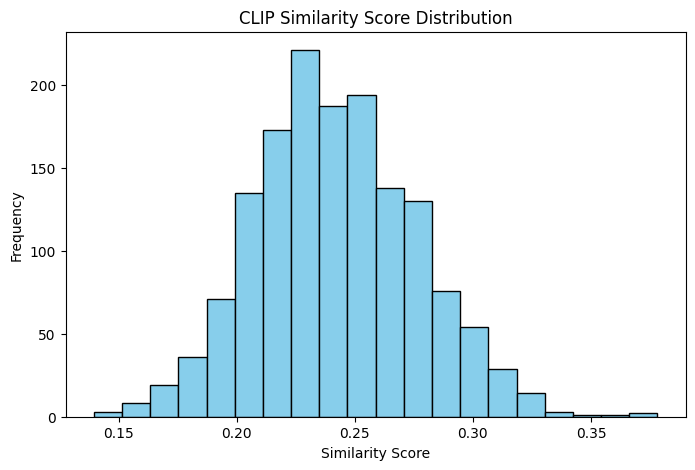

In [84]:
import matplotlib.pyplot as plt

# Load CLIP similarity scores from JSON
clip_json_path = "/content/drive/MyDrive/vr_dataset/clip/clip_fast.json"
with open(clip_json_path, "r") as file:
    clip_data = json.load(file)

# Extract similarity scores
similarity_scores = [entry["similarity_score"] for entry in clip_data.values()]

# Compute Metrics
mean_score = np.mean(similarity_scores)
median_score = np.median(similarity_scores)
std_dev = np.std(similarity_scores)

print(f" Mean Similarity Score: {mean_score:.4f}")
print(f" Median Similarity Score: {median_score:.4f}")
print(f" Standard Deviation: {std_dev:.4f}")

# Plot Distribution of Similarity Scores
plt.figure(figsize=(8, 5))
plt.hist(similarity_scores, bins=20, color="skyblue", edgecolor="black")
plt.xlabel("Similarity Score")
plt.ylabel("Frequency")
plt.title("CLIP Similarity Score Distribution")
plt.show()


# Creating the dataset for fine tuning

In [ ]:
!pip install bert-score


In [ ]:
# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"  # Select GPU if available, otherwise fallback to CPU

# Load CLIP model, processor, tokenizer
model_name = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(model_name).to(device)  # Load pre-trained CLIP model and move it to the selected device
processor = CLIPProcessor.from_pretrained(model_name)  # Load processor for handling text and images
tokenizer = AutoTokenizer.from_pretrained(model_name)  # Load tokenizer to process text input

# Define file paths
image_folder = "/content/drive/MyDrive/vr_dataset/img"  # Path to image dataset
metadata_path = "/content/drive/MyDrive/vr_dataset/split1.csv"  # Metadata linking image IDs to file paths
qna_json_path = "/content/drive/MyDrive/vr_dataset/QNA/qna_fast_cleaned.json"  # Q&A dataset path
clip_json_path = "/content/drive/MyDrive/vr_dataset/clip/clip_fast_lora.json"  # Preprocessed CLIP output path
output_pt_path = "/content/drive/MyDrive/vr_dataset/processed_dataset.pt"  # Output path for saving processed dataset

# Load metadata CSV and map image IDs to file paths
metadata_df = pd.read_csv(metadata_path)  # Load metadata file
image_id_to_path = dict(zip(metadata_df["image_id"].astype(str), metadata_df["path"]))  # Create mapping of image IDs to paths

# Load Q&A dataset
with open(qna_json_path, "r") as f:
    qna_data = json.load(f)  # Load JSON containing Q&A pairs

# Load CLIP preprocessed data
with open(clip_json_path, "r") as f:
    clip_data = json.load(f)  # Load JSON containing CLIP output data

# Define image transformation pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize image to standard CLIP input size
    transforms.ToTensor(),  # Convert image to tensor format for processing
])

# Function to load and transform image tensors
def load_image_tensor(image_id):
    """Loads an image, converts it to RGB, applies transformations, and returns a tensor."""
    if image_id in image_id_to_path:  # Check if image ID exists in metadata
        image_path = os.path.join(image_folder, image_id_to_path[image_id])  # Construct full image path
        if os.path.exists(image_path):  # Verify image file exists
            image = Image.open(image_path).convert("RGB")  # Load and convert to RGB
            return transform(image).unsqueeze(0).to(device)  # Apply transformation and return tensor
    return None  # Return None if image not found

# Initialize dataset storage
dataset = []

# Process images and Q&A for CLIP embeddings
for image_id, clip_entries in tqdm(clip_data.items(), desc="Processing dataset"):
    if not isinstance(clip_entries, list):
        clip_entries = [clip_entries]  # Ensure data structure compatibility

    for entry in clip_entries:
        question = entry.get("question", "").strip()  # Retrieve and clean question
        answer = entry.get("answer", "").strip()  # Retrieve and clean answer
        similarity_score = entry.get("similarity_score", 0)  # Default similarity score if missing

        # Load image tensor for CLIP
        image_tensor = load_image_tensor(image_id)
        if image_tensor is None:  # Skip if image not found
            continue

        # Tokenize text input (question + answer)
        text_input = tokenizer(f"{question} {answer}", return_tensors="pt", padding=True).to(device)

        # Extract embeddings using CLIP model
        with torch.no_grad():  # Disable gradients for efficiency
            image_emb = model.get_image_features(pixel_values=image_tensor).squeeze(0)  # Extract image embeddings
            text_emb = model.get_text_features(**text_input).squeeze(0)  # Extract text embeddings

        # Define label based on similarity threshold
        label = 1 if similarity_score > 0.2 else 0  # Binary classification

        # Store processed data in dataset list
        dataset.append({
            "image_id": image_id,  # Store image ID
            "question": question,  # Store question text
            "answer": answer,  # Store answer text
            "similarity_score": similarity_score,  # Store similarity score
            "input_ids": text_input["input_ids"].squeeze(0).cpu(),  # Tokenized input IDs
            "attention_mask": text_input["attention_mask"].squeeze(0).cpu(),  # Attention mask for transformer model
            "position_ids": torch.arange(text_input["input_ids"].size(1)),  # Positional encoding for text input
            "pixel_values": image_emb.cpu(),  # Image embeddings
            "text_embedding": text_emb.cpu(),  # Text embeddings
            "label": torch.tensor(label, dtype=torch.long),  # Store label for training
            # Additional placeholders for compatibility with future models
            "return_loss": False,
            "output_attentions": None,
            "output_hidden_states": None,
            "interpolate_pos_encoding": False,
        })

# Save the processed dataset to a .pt file for later use
torch.save(dataset, output_pt_path)

print(f" Dataset saved successfully at {output_pt_path}")  # Confirmation message


# Training the model without fine tuning

In [10]:
from torch.nn.utils.rnn import pad_sequence  # Utility function for padding sequences of different lengths

device = "cuda" if torch.cuda.is_available() else "cpu"  # Checks if a GPU is available, otherwise falls back to CPU

# Paths for dataset, images, and metadata
dataset_path = "/content/drive/MyDrive/vr_dataset/processed_dataset.pt"  # Path to preprocessed dataset
image_folder = "/content/drive/MyDrive/vr_dataset/img"  # Directory containing images
metadata_path = "/content/drive/MyDrive/vr_dataset/split1.csv"  # CSV file containing metadata about images

import pandas as pd
metadata_df = pd.read_csv(metadata_path)  # Load metadata file
image_id_to_path = dict(zip(metadata_df["image_id"].astype(str), metadata_df["path"]))  # Map image IDs to file paths

# Load CLIP processor and model
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")  # CLIP processor for handling text and images
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)  # Load pre-trained CLIP model and move to the selected device
model.train()  # Set model in training mode

# Load dataset
dataset = torch.load(dataset_path)  # Load processed dataset from .pt file

# Define a custom dataset class for handling VQA (Visual Question Answering) data
class VQADataset(Dataset):
    def __init__(self, data, image_id_to_path, image_folder, processor):
        self.data = data  # Store dataset
        self.image_id_to_path = image_id_to_path  # Map image IDs to paths
        self.image_folder = image_folder  # Location of images
        self.processor = processor  # CLIP processor for text and image processing

    def __len__(self):
        return len(self.data)  # Return dataset length

    def __getitem__(self, idx):
        """Retrieve and preprocess an item (image, question, answer, label)"""
        item = self.data[idx]  # Get dataset entry
        image_id = item["image_id"]
        question = item["question"]
        answer = item["answer"]
        label = item["label"]

        # Load raw image file
        image_path = os.path.join(self.image_folder, self.image_id_to_path[image_id])  # Construct full image path
        image = Image.open(image_path).convert("RGB")  # Open image and convert to RGB format

        # Process inputs with CLIP processor: text and image
        inputs = self.processor(text=question + " " + answer, images=image, return_tensors="pt", padding=True)

        input_ids = inputs["input_ids"].squeeze(0)  # Extract tokenized text
        attention_mask = inputs["attention_mask"].squeeze(0)  # Extract attention mask
        pixel_values = inputs["pixel_values"].squeeze(0)  # Extract preprocessed image tensor

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "pixel_values": pixel_values,
            "label": label,  # Ground-truth label (1 or 0)
        }

# Function to collate batches of data
def collate_fn(batch):
    input_ids = [item["input_ids"] for item in batch]
    attention_mask = [item["attention_mask"] for item in batch]
    pixel_values = torch.stack([item["pixel_values"] for item in batch])  # Stack image tensors (batch_size, 3, 224, 224)
    labels = torch.stack([item["label"] for item in batch])  # Stack labels

    # Pad tokenized text inputs to match the longest sequence in the batch
    input_ids_padded = pad_sequence(input_ids, batch_first=True, padding_value=processor.tokenizer.pad_token_id)
    attention_mask_padded = pad_sequence(attention_mask, batch_first=True, padding_value=0)  # Padding for attention mask

    return {
        "input_ids": input_ids_padded,
        "attention_mask": attention_mask_padded,
        "pixel_values": pixel_values,
        "label": labels,
    }

# Create dataset and data loader
train_dataset = VQADataset(dataset, image_id_to_path, image_folder, processor)  # Initialize dataset
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)  # Data loader with batch size 8

# Define optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)  # AdamW optimizer with learning rate 5e-5
criterion = torch.nn.BCEWithLogitsLoss()  # Binary Cross-Entropy loss for classification task

# Training loop
epochs = 3  # Define number of epochs

for epoch in range(epochs):
    model.train()  # Set model in training mode
    total_loss = 0  # Track total loss across batches
    all_preds = []  # Track predictions
    all_labels = []  # Track ground-truth labels

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}")  # Initialize progress bar
    for batch in loop:
        optimizer.zero_grad()  # Reset gradients

        # Move batch data to the selected device
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["label"].to(device).float()

        # Get CLIP embeddings for image and text
        image_embeds = model.get_image_features(pixel_values=pixel_values)  # Extract image embeddings (batch, 512)
        text_embeds = model.get_text_features(input_ids=input_ids, attention_mask=attention_mask)  # Extract text embeddings (batch, 512)

        # Normalize embeddings to unit length
        image_embeds = image_embeds / image_embeds.norm(p=2, dim=-1, keepdim=True)
        text_embeds = text_embeds / text_embeds.norm(p=2, dim=-1, keepdim=True)

        # Compute cosine similarity between image and text embeddings
        cosine_sim = (image_embeds * text_embeds).sum(dim=-1)  # Compute similarity score per batch

        # Compute loss and backpropagate
        loss = criterion(cosine_sim, labels)  # Compute BCE loss
        loss.backward()  # Backpropagate gradients
        optimizer.step()  # Update model weights

        # Track loss and predictions
        total_loss += loss.item()
        preds = (torch.sigmoid(cosine_sim) > 0.5).long()  # Convert similarity scores to binary predictions
        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

        loop.set_postfix(loss=loss.item())  # Update progress bar with current loss

    # Compute accuracy
    acc = (torch.tensor(all_preds) == torch.tensor(all_labels)).float().mean().item()
    print(f"Epoch {epoch+1} - Loss: {total_loss/len(train_loader):.4f} - Accuracy: {acc:.4f}")

print(" Training complete!")


Epoch 1: 100%|██████████| 187/187 [00:36<00:00,  5.10it/s, loss=0.456]


Epoch 1 - Loss: 0.4163 - Accuracy: 0.9023


Epoch 2: 100%|██████████| 187/187 [00:34<00:00,  5.35it/s, loss=0.313]


Epoch 2 - Loss: 0.4109 - Accuracy: 0.9023


Epoch 3: 100%|██████████| 187/187 [00:35<00:00,  5.27it/s, loss=0.599]

Epoch 3 - Loss: 0.4111 - Accuracy: 0.9023
Training complete!


# Getting the evaluation metrices

In [11]:
from sklearn.metrics import f1_score  # Import F1 score metric for classification evaluation
from bert_score import score as bert_score  # Import BERTScore for text similarity evaluation
import torch  # Import PyTorch for deep learning computations

# Set the model to evaluation mode (disables dropout and ensures deterministic behavior)
model.eval()

# Initialize lists to store predictions, labels, questions, and answers
all_preds = []  # Stores predicted labels (binary: 0 or 1)
all_labels = []  # Stores actual labels (ground truth)
all_questions = []  # Stores reference (original) questions for BERTScore evaluation
all_answers = []  # Stores predicted answers for BERTScore evaluation

# Disable gradient computation for evaluation (improves efficiency)
with torch.no_grad():
    for batch in train_loader:  # Iterate through the data loader (batches of processed data)
        # Move batch elements to the selected device (GPU or CPU)
        input_ids = batch["input_ids"].to(device)  # Tokenized text inputs
        attention_mask = batch["attention_mask"].to(device)  # Attention mask for text
        pixel_values = batch["pixel_values"].to(device)  # Image tensor
        labels = batch["label"].to(device)  # Ground truth labels

        # Extract embeddings from CLIP for images and text
        image_embeds = model.get_image_features(pixel_values=pixel_values)  # Image feature extraction
        text_embeds = model.get_text_features(input_ids=input_ids, attention_mask=attention_mask)  # Text feature extraction

        # Normalize embeddings for cosine similarity computation (prevents scale variance)
        image_embeds = image_embeds / image_embeds.norm(p=2, dim=-1, keepdim=True)
        text_embeds = text_embeds / text_embeds.norm(p=2, dim=-1, keepdim=True)

        # Compute cosine similarity between image and text embeddings
        cosine_sim = (image_embeds * text_embeds).sum(dim=-1)  # Measures alignment of image and text

        # Convert cosine similarity scores into binary predictions (threshold at 0.5)
        preds = (torch.sigmoid(cosine_sim) > 0.5).long()

        # Store predictions and labels
        all_preds.extend(preds.cpu().tolist())  # Convert to list and move to CPU
        all_labels.extend(labels.cpu().tolist())  # Convert to list and move to CPU

        # Prepare questions and answers for BERTScore evaluation
        batch_size = input_ids.size(0)
        for i in range(batch_size):
            input_ids_i = input_ids[i]
            # Decode tokenized text back into a readable string
            question_answer_text = tokenizer.decode(input_ids_i, skip_special_tokens=True)
            all_answers.append(question_answer_text)  # Store predicted text (question + answer)
            all_questions.append(question_answer_text)  # Use the same text as reference for simplicity

# Calculate F1 score for classification accuracy
f1 = f1_score(all_labels, all_preds)
print(f"F1 Score: {f1:.4f}")  # Print classification F1 score

# Compute BERTScore for text similarity evaluation
P, R, F1_bert = bert_score(cands=all_answers, refs=all_questions, lang='en', verbose=True)
print(f"BERTScore F1: {F1_bert.mean().item():.4f}")  # Print BERTScore F1 score


F1 Score: 0.9487


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/22 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/24 [00:00<?, ?it/s]

done in 3.18 seconds, 470.18 sentences/sec
BERTScore F1: 1.0000


In [ ]:
pip install peft


# Lora fine tuning

In [26]:
from torch.utils.data import Dataset, DataLoader  # For dataset handling and batch processing
from torch.nn.utils.rnn import pad_sequence  # Utility to pad sequences to equal length
from peft import get_peft_model, LoraConfig, TaskType  # LoRA (Low-Rank Adaptation) for efficient fine-tuning

from sklearn.model_selection import train_test_split  # For splitting dataset into train/val/test
from sklearn.metrics import f1_score  # F1-score evaluation metric
import pandas as pd  # Data manipulation
import bert_score  # BERT-based evaluation metric for text similarity

device = "cuda" if torch.cuda.is_available() else "cpu"  # Use GPU if available, else fallback to CPU

# Paths (adjust if needed)
dataset_path = "/content/drive/MyDrive/vr_dataset/processed_dataset.pt"  # Path to preprocessed dataset
image_folder = "/content/drive/MyDrive/vr_dataset/img"  # Folder containing image data
metadata_path = "/content/drive/MyDrive/vr_dataset/split1.csv"  # CSV metadata mapping image IDs to file paths

# Load metadata and create mapping from image_id to file path
metadata_df = pd.read_csv(metadata_path)
image_id_to_path = dict(zip(metadata_df["image_id"].astype(str), metadata_df["path"]))

# Load CLIP processor and model
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")  # Handles text and images
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)  # Loads CLIP model on specified device

# Configure LoRA adapters for efficient fine-tuning of CLIP
lora_config = LoraConfig(
    r=8,  # LoRA rank (lower values for less memory usage)
    lora_alpha=16,  # Scaling factor for LoRA updates
    target_modules=["q_proj", "v_proj"],  # Apply LoRA to query and value projection layers
    lora_dropout=0.1,  # Dropout for regularization
    bias="none",  # No bias in LoRA layers
    task_type=TaskType.FEATURE_EXTRACTION,  # Task type for fine-tuning
)

# Apply LoRA configuration to CLIP model
model = get_peft_model(model, lora_config)
model.train()  # Enable training mode

# Load dataset from preprocessed .pt file
dataset = torch.load(dataset_path)

# Split dataset into train, validation, and test sets with stratified labels
train_val_data, test_data = train_test_split(dataset, test_size=0.1, random_state=42, stratify=[item['label'] for item in dataset])
train_data, val_data = train_test_split(train_val_data, test_size=0.1, random_state=42, stratify=[item['label'] for item in train_val_data])

# Define custom PyTorch dataset for VQA (Visual Question Answering)
class VQADataset(Dataset):
    def __init__(self, data, image_id_to_path, image_folder, processor):
        self.data = data  # Store dataset
        self.image_id_to_path = image_id_to_path  # Mapping of image ID to file path
        self.image_folder = image_folder  # Folder containing images
        self.processor = processor  # CLIP processor for text and images

    def __len__(self):
        return len(self.data)  # Return dataset length

    def __getitem__(self, idx):
        """Loads and preprocesses an image, question-answer pair, and label"""
        item = self.data[idx]
        image_id = item["image_id"]
        question = item["question"]
        answer = item["answer"]
        label = item["label"]

        # Load image from correct path
        image_path = os.path.join(self.image_folder, self.image_id_to_path[image_id])
        image = Image.open(image_path).convert("RGB")  # Convert to RGB format

        # Process text and image inputs for CLIP
        inputs = self.processor(text=question + " " + answer, images=image, return_tensors="pt", padding=True)

        return {
            "input_ids": inputs["input_ids"].squeeze(0),  # Tokenized text inputs
            "attention_mask": inputs["attention_mask"].squeeze(0),  # Attention mask
            "pixel_values": inputs["pixel_values"].squeeze(0),  # Preprocessed image tensor
            "label": label,  # Ground-truth label
            "question": question,  # Question text (kept for evaluation)
            "answer": answer,  # Answer text (kept for evaluation)
        }

# Function to collate batches for efficient processing
def collate_fn(batch):
    input_ids = [item["input_ids"] for item in batch]
    attention_mask = [item["attention_mask"] for item in batch]
    pixel_values = torch.stack([item["pixel_values"] for item in batch])  # Stack image tensors
    labels = torch.stack([item["label"] for item in batch])  # Stack labels

    # Pad tokenized text inputs to the longest sequence in the batch
    input_ids_padded = pad_sequence(input_ids, batch_first=True, padding_value=processor.tokenizer.pad_token_id)
    attention_mask_padded = pad_sequence(attention_mask, batch_first=True, padding_value=0)

    return {
        "input_ids": input_ids_padded,
        "attention_mask": attention_mask_padded,
        "pixel_values": pixel_values,
        "label": labels,
        "batch_raw": batch,  # Keep raw items for BERTScore evaluation
    }

# Create DataLoaders for train, validation, and test sets
train_loader = DataLoader(VQADataset(train_data, image_id_to_path, image_folder, processor), batch_size=8, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(VQADataset(val_data, image_id_to_path, image_folder, processor), batch_size=8, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(VQADataset(test_data, image_id_to_path, image_folder, processor), batch_size=8, shuffle=False, collate_fn=collate_fn)

# Define optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)  # AdamW optimizer with higher lr for LoRA fine-tuning
criterion = torch.nn.BCEWithLogitsLoss()  # Binary cross-entropy loss

# Training loop
epochs = 10  # Number of training epochs

for epoch in range(epochs):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    for batch in loop:
        optimizer.zero_grad()

        # Move batch data to the selected device
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["label"].to(device).float()

        # Extract CLIP embeddings
        image_embeds = model.get_image_features(pixel_values=pixel_values)
        text_embeds = model.get_text_features(input_ids=input_ids, attention_mask=attention_mask)

        # Normalize embeddings before cosine similarity calculation
        image_embeds = image_embeds / image_embeds.norm(p=2, dim=-1, keepdim=True)
        text_embeds = text_embeds / text_embeds.norm(p=2, dim=-1, keepdim=True)

        # Compute similarity scores
        cosine_sim = (image_embeds * text_embeds).sum(dim=-1)

        # Compute loss and backpropagation
        loss = criterion(cosine_sim, labels)
        loss.backward()
        optimizer.step()

        # Track loss and predictions
        total_loss += loss.item()
        preds = (torch.sigmoid(cosine_sim) > 0.5).long()
        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

        loop.set_postfix(loss=loss.item())

    # Compute accuracy
    acc = (torch.tensor(all_preds) == torch.tensor(all_labels)).float().mean().item()
    print(f"Epoch {epoch+1} - Loss: {total_loss/len(train_loader):.4f} - Accuracy: {acc:.4f}")

print(" LoRA fine-tuning complete!")


Epoch 1: 100%|██████████| 152/152 [00:21<00:00,  7.18it/s, loss=0.813]


Epoch 1 - Loss: 0.4467 - Accuracy: 0.9025


Epoch 2: 100%|██████████| 152/152 [00:22<00:00,  6.66it/s, loss=0.314]


Epoch 2 - Loss: 0.4105 - Accuracy: 0.9025


Epoch 3: 100%|██████████| 152/152 [00:20<00:00,  7.51it/s, loss=0.313]


Epoch 3 - Loss: 0.4093 - Accuracy: 0.9033


Epoch 4: 100%|██████████| 152/152 [00:21<00:00,  7.23it/s, loss=0.314]


Epoch 4 - Loss: 0.4066 - Accuracy: 0.9066


Epoch 5: 100%|██████████| 152/152 [00:20<00:00,  7.43it/s, loss=0.313]


Epoch 5 - Loss: 0.4057 - Accuracy: 0.9074


Epoch 6: 100%|██████████| 152/152 [00:20<00:00,  7.26it/s, loss=0.313]


Epoch 6 - Loss: 0.4056 - Accuracy: 0.9074


Epoch 7: 100%|██████████| 152/152 [00:21<00:00,  7.23it/s, loss=0.313]


Epoch 7 - Loss: 0.4055 - Accuracy: 0.9074


Epoch 8: 100%|██████████| 152/152 [00:20<00:00,  7.50it/s, loss=0.313]


Epoch 8 - Loss: 0.4055 - Accuracy: 0.9074


Epoch 9: 100%|██████████| 152/152 [00:21<00:00,  7.23it/s, loss=0.313]


Epoch 9 - Loss: 0.4055 - Accuracy: 0.9074


Epoch 10: 100%|██████████| 152/152 [00:26<00:00,  5.77it/s, loss=0.313]

Epoch 10 - Loss: 0.4055 - Accuracy: 0.9074
LoRA fine-tuning complete!


# Displaying the evaluation metrices

In [29]:
from sklearn.metrics import f1_score  # Import F1 score for classification evaluation
from tqdm import tqdm  # Import tqdm for progress bar
import torch  # Import PyTorch for tensor computations

# Function to evaluate the model on validation/test datasets
def evaluate(loader):
    model.eval()  # Set model to evaluation mode (disables dropout, batch norm adjustments)
    all_preds = []  # Store predictions
    all_labels = []  # Store actual labels

    # Disable gradient computation during evaluation for efficiency
    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating"):  # Iterate over dataset with progress bar
            # Move batch data to the selected device (GPU/CPU)
            input_ids = batch["input_ids"].to(device)  # Tokenized text inputs
            attention_mask = batch["attention_mask"].to(device)  # Attention mask for text processing
            pixel_values = batch["pixel_values"].to(device)  # Image tensor
            labels = batch["label"].to(device).float()  # Ground truth labels

            # Extract image and text embeddings using CLIP model
            image_embeds = model.get_image_features(pixel_values=pixel_values)  # Get image feature embeddings
            text_embeds = model.get_text_features(input_ids=input_ids, attention_mask=attention_mask)  # Get text feature embeddings

            # Normalize embeddings before computing similarity (prevents scale-related issues)
            image_embeds = image_embeds / image_embeds.norm(p=2, dim=-1, keepdim=True)
            text_embeds = text_embeds / text_embeds.norm(p=2, dim=-1, keepdim=True)

            # Compute cosine similarity between image and text embeddings
            cosine_sim = (image_embeds * text_embeds).sum(dim=-1)  # Compute similarity score

            # Convert similarity scores to binary predictions using a threshold (0.5 by default)
            preds = (torch.sigmoid(cosine_sim) > 0.5).long()

            # Store predictions and actual labels
            all_preds.extend(preds.cpu().tolist())  # Move predictions to CPU and convert to list
            all_labels.extend(labels.cpu().tolist())  # Move labels to CPU and convert to list

    # Calculate F1 score for classification performance
    f1 = f1_score(all_labels, all_preds)

    # Calculate accuracy
    accuracy = (torch.tensor(all_preds) == torch.tensor(all_labels)).float().mean().item()

    print(f"Accuracy: {accuracy:.4f} - F1 Score: {f1:.4f}")  # Print evaluation metrics

    return f1, accuracy  # Return F1 score and accuracy values

# Evaluate model on validation dataset
print("Validation evaluation:")
evaluate(val_loader)

# Evaluate model on test dataset
print("Test evaluation:")
evaluate(test_loader)


Validation evaluation:


Evaluating: 100%|██████████| 17/17 [00:02<00:00,  7.80it/s]


Accuracy: 0.9037 - F1 score: 0.9494
Test evaluation:


Evaluating: 100%|██████████| 19/19 [00:02<00:00,  7.41it/s]

Accuracy: 0.9000 - F1 score: 0.9474


(0.9473684210526315, 0.8999999761581421)

In [45]:
from sklearn.metrics import confusion_matrix, precision_score  # Import evaluation metrics for classification

# Initialize lists to store predictions and labels
all_preds = []  # Stores predicted labels
all_labels = []  # Stores actual ground-truth labels

# Training loop for multiple epochs
for epoch in range(epochs):
    model.train()  # Set model to training mode
    total_loss = 0  # Initialize total loss counter

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}")  # Progress bar for training
    for batch in loop:
        optimizer.zero_grad()  # Reset gradients before each batch

        # Move batch data to the selected device (GPU/CPU)
        input_ids = batch["input_ids"].to(device)  # Tokenized text input
        attention_mask = batch["attention_mask"].to(device)  # Attention mask for text processing
        pixel_values = batch["pixel_values"].to(device)  # Image tensor
        labels = batch["label"].to(device).float()  # Ground-truth labels

        # Get embeddings from CLIP model
        image_embeds = model.get_image_features(pixel_values=pixel_values)  # Extract image embeddings
        text_embeds = model.get_text_features(input_ids=input_ids, attention_mask=attention_mask)  # Extract text embeddings

        # Normalize embeddings before computing similarity (prevents scale-related issues)
        image_embeds = image_embeds / image_embeds.norm(p=2, dim=-1, keepdim=True)
        text_embeds = text_embeds / text_embeds.norm(p=2, dim=-1, keepdim=True)

        # Compute cosine similarity between image and text embeddings
        cosine_sim = (image_embeds * text_embeds).sum(dim=-1)  # Measures alignment between image and text

        # Compute loss using Binary Cross-Entropy with Logits
        loss = criterion(cosine_sim, labels)
        loss.backward()  # Compute gradients
        optimizer.step()  # Update model parameters

        # Track loss and predictions
        total_loss += loss.item()
        preds = (torch.sigmoid(cosine_sim) > 0.5).long()  # Apply threshold (0.5) for classification
        all_preds.extend(preds.cpu().tolist())  # Convert to list
        all_labels.extend(labels.cpu().tolist())  # Convert to list

        loop.set_postfix(loss=loss.item())  # Update progress bar with loss value

    # Calculate accuracy for the epoch
    acc = (torch.tensor(all_preds) == torch.tensor(all_labels)).float().mean().item()
    print(f"Epoch {epoch+1} - Loss: {total_loss/len(train_loader):.4f}")  # Print loss per epoch

# Evaluation after training:
from sklearn.metrics import confusion_matrix, precision_score  # Import additional metrics

# Compute confusion matrix for classification performance
cm = confusion_matrix(all_labels, all_preds)  # Confusion matrix shows TP, FP, FN, TN
precision = precision_score(all_labels, all_preds)  # Compute precision (TP / (TP + FP))

# Print final evaluation results
print(f"\nFinal Results after {epochs} epochs:")
print(f"Accuracy: {acc:.4f}")  # Print final accuracy
print(f"Precision: {precision:.4f}")  # Print precision metric
print("Confusion Matrix:")
print(cm)  # Print confusion matrix to analyze predictions


Epoch 1: 100%|██████████| 152/152 [00:23<00:00,  6.48it/s, loss=0.314]


Epoch 1 - Loss: 0.4057


Epoch 2: 100%|██████████| 152/152 [00:20<00:00,  7.29it/s, loss=0.313]


Epoch 2 - Loss: 0.4054


Epoch 3: 100%|██████████| 152/152 [00:20<00:00,  7.54it/s, loss=0.313]


Epoch 3 - Loss: 0.4054


Epoch 4: 100%|██████████| 152/152 [00:20<00:00,  7.36it/s, loss=0.313]


Epoch 4 - Loss: 0.4054


Epoch 5: 100%|██████████| 152/152 [00:20<00:00,  7.55it/s, loss=0.313]


Epoch 5 - Loss: 0.4054


Epoch 6: 100%|██████████| 152/152 [00:20<00:00,  7.29it/s, loss=0.313]


Epoch 6 - Loss: 0.4054


Epoch 7: 100%|██████████| 152/152 [00:20<00:00,  7.46it/s, loss=0.313]


Epoch 7 - Loss: 0.4055


Epoch 8: 100%|██████████| 152/152 [00:20<00:00,  7.38it/s, loss=0.813]


Epoch 8 - Loss: 0.4079


Epoch 9: 100%|██████████| 152/152 [00:20<00:00,  7.27it/s, loss=0.313]


Epoch 9 - Loss: 0.4054


Epoch 10: 100%|██████████| 152/152 [00:19<00:00,  7.63it/s, loss=0.313]

Epoch 10 - Loss: 0.4054

Final Results after 10 epochs:
Accuracy: 0.9074
Precision: 0.9070
Confusion Matrix:
[[   60  1120]
 [    0 10920]]


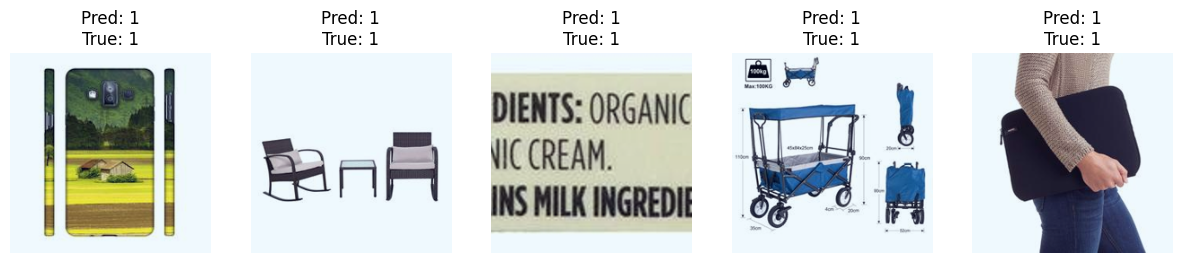

In [43]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(loader, num_samples=5):
    model.eval()
    images_to_show = []
    pred_labels = []
    true_labels = []

    with torch.no_grad():
        for batch in loader:
            pixel_values = batch["pixel_values"].to(device)
            labels = batch["label"].to(device).float()

            # Get embeddings and predictions
            image_embeds = model.get_image_features(pixel_values=pixel_values)
            text_embeds = model.get_text_features(
                input_ids=batch["input_ids"].to(device),
                attention_mask=batch["attention_mask"].to(device)
            )
            image_embeds = image_embeds / image_embeds.norm(p=2, dim=-1, keepdim=True)
            text_embeds = text_embeds / text_embeds.norm(p=2, dim=-1, keepdim=True)
            cosine_sim = (image_embeds * text_embeds).sum(dim=-1)
            preds = (torch.sigmoid(cosine_sim) > 0.5).long()

            # Collect for visualization (convert images to CPU numpy)
            for i in range(len(labels)):
                if len(images_to_show) >= num_samples:
                    break
                img = pixel_values[i].cpu().permute(1, 2, 0).numpy()  # Convert CHW to HWC
                # Normalize image for display if needed
                img = (img - img.min()) / (img.max() - img.min() + 1e-5)

                images_to_show.append(img)
                pred_labels.append(preds[i].item())
                true_labels.append(int(labels[i].item()))

            if len(images_to_show) >= num_samples:
                break

    # Plot images with predicted and true labels
    plt.figure(figsize=(15, 4))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(images_to_show[i])
        plt.title(f"Pred: {pred_labels[i]}\nTrue: {true_labels[i]}")
        plt.axis('off')
    plt.show()

# Example usage:
visualize_predictions(val_loader, num_samples=5)


In [46]:
import bert_score  # Import BERTScore for evaluating text similarity

# Set model to evaluation mode (disables dropout & batch normalization adjustments)
model.eval()

# Initialize lists to store candidate answers and reference answers
candidate_answers = []  # Stores predicted answers
reference_answers = []  # Stores reference (original) questions for comparison

# Disable gradient computation for evaluation (improves efficiency)
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Calculating BERTScore"):  # Iterate through test dataset with a progress bar
        # Move batch data to the selected device (GPU/CPU)
        input_ids = batch["input_ids"].to(device)  # Tokenized text inputs
        attention_mask = batch["attention_mask"].to(device)  # Attention mask for text processing
        pixel_values = batch["pixel_values"].to(device)  # Image tensor

        # Extract embeddings using CLIP model
        image_embeds = model.get_image_features(pixel_values=pixel_values)  # Get image embeddings
        text_embeds = model.get_text_features(input_ids=input_ids, attention_mask=attention_mask)  # Get text embeddings

        # Normalize embeddings to unit length before computing cosine similarity
        image_embeds = image_embeds / image_embeds.norm(p=2, dim=-1, keepdim=True)
        text_embeds = text_embeds / text_embeds.norm(p=2, dim=-1, keepdim=True)

        # Compute cosine similarity between image and text embeddings
        cosine_sim = (image_embeds * text_embeds).sum(dim=-1)  # Compute similarity score

        # Convert similarity scores to binary predictions using a threshold (0.5)
        preds = (torch.sigmoid(cosine_sim) > 0.5).long().cpu().tolist()

        # Store predictions where the model thinks the question-answer pair matches the image
        for i, item in enumerate(batch["batch_raw"]):
            if preds[i] == 1:  # If model predicts a match
                candidate_answers.append(item["answer"])  # Store predicted answer
                reference_answers.append(item["question"])  # Use question as reference for comparison


Calculating BERTScore: 100%|██████████| 19/19 [00:02<00:00,  8.82it/s]


In [47]:
P, R, F1 = bert_score.score(candidate_answers, reference_answers, lang="en", verbose=True)

print(f"\nBERTScore:")
print(f"Precision: {P.mean().item():.4f}")
print(f"Recall:    {R.mean().item():.4f}")
print(f"F1:        {F1.mean().item():.4f}")


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/4 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/3 [00:00<?, ?it/s]

done in 0.70 seconds, 214.34 sentences/sec

BERTScore:
Precision: 0.8514
Recall:    0.8137
F1:        0.8319
